In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/description.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data_solution.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt


In [10]:
import tensorflow as tf
import numpy as np
import scipy
from scipy import misc
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt
import librosa
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pydub import AudioSegment
import shutil
from keras.preprocessing.image import ImageDataGenerator
import random
print(tf.__version__)

2.12.0


In [11]:
train_df = pd.read_csv("/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt",
                       engine="python",
                       sep=" ::: ",
                       names=["id", "movie", "genre", "summary"])

test_df = pd.read_csv("/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data_solution.txt",
                      engine="python",
                      sep=" ::: ",
                      names=["id", "movie", "genre", "summary"])


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       54214 non-null  int64 
 1   movie    54214 non-null  object
 2   genre    54214 non-null  object
 3   summary  54214 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


In [13]:
train_df.dropna()

,id,movie,genre,summary
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...
...,...,...,...,...
54209,54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on B...
54210,54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The siste...
54211,54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about gr..."
54212,54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and have...


In [14]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54200 entries, 0 to 54199
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       54200 non-null  int64 
 1   movie    54200 non-null  object
 2   genre    54200 non-null  object
 3   summary  54200 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


In [15]:
test_df.dropna()

,id,movie,genre,summary
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apart..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty chi..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family o...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with his..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a marti...
...,...,...,...,...
54195,54196,"""Tales of Light & Dark"" (2013)",horror,"Covering multiple genres, Tales of Light & Dar..."
54196,54197,Der letzte Mohikaner (1965),western,As Alice and Cora Munro attempt to find their ...
54197,54198,Oliver Twink (2007),adult,"A movie 169 years in the making. Oliver Twist,..."
54198,54199,Slipstream (1973),drama,"Popular, but mysterious rock D.J Mike Mallard ..."


In [16]:
train_df.shape

(54214, 4)

In [17]:
test_df.shape

(54200, 4)

In [18]:
train_df.count()

id         54214
movie      54214
genre      54214
summary    54214
dtype: int64

In [19]:
test_df.count()

id         54200
movie      54200
genre      54200
summary    54200
dtype: int64

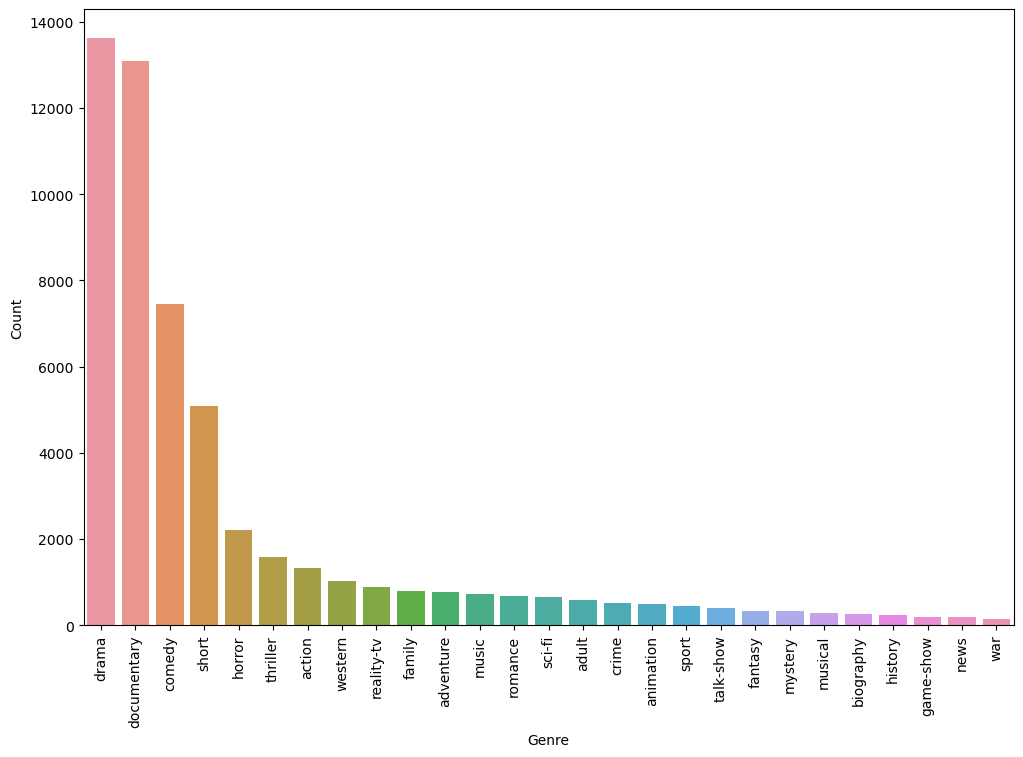

In [20]:
import seaborn as sns
plt.figure(figsize=(12,8))
counts = train_df.genre.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=90);

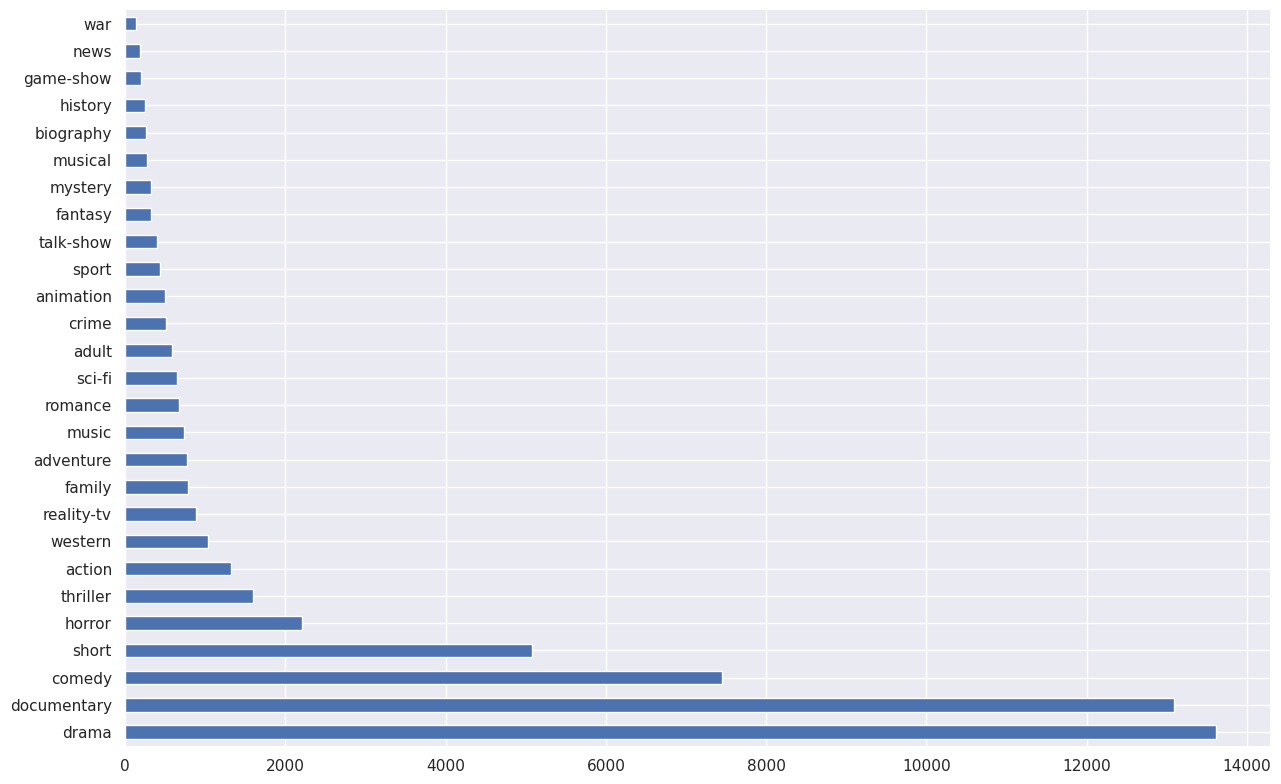

In [21]:
plt.figure(figsize=(13,8))

sns.set(style="darkgrid")
sns.set_color_codes("pastel")
train_df.genre.value_counts().plot.barh()
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

<Axes: xlabel='count', ylabel='genre'>

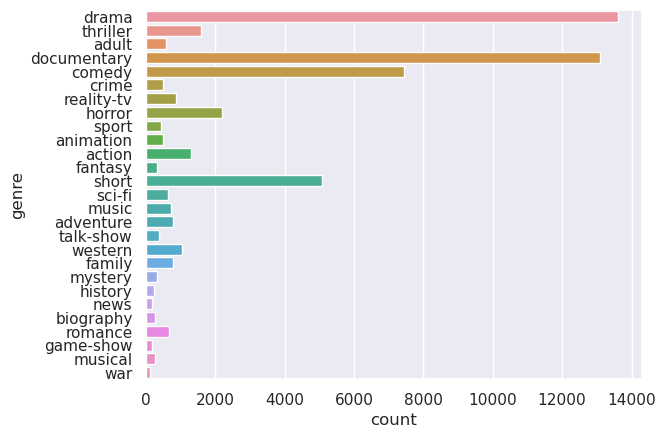

In [22]:
sns.countplot(y='genre',data=train_df)

/tmp/ipykernel_32/2495130065.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_df.corr()


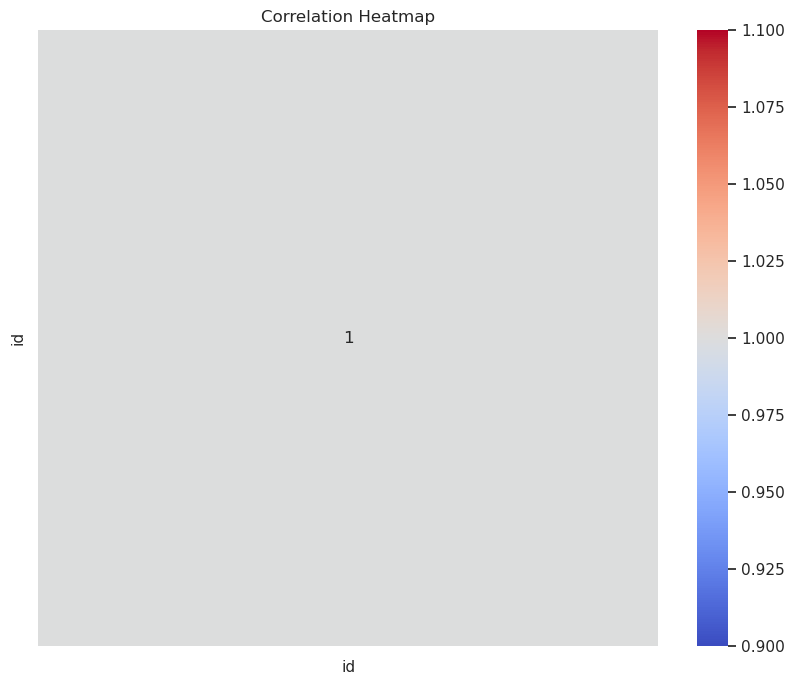

In [23]:
plt.figure(figsize=(10, 8))
correlation_matrix = train_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [24]:
train_df = pd.read_csv('../input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt', sep=":::", header=None, engine='python')
test_df = pd.read_csv('../input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data_solution.txt', sep=":::", header=None, engine='python')
train_df.columns=['id','title','genre','description']
test_df.columns=['id','title','genre','description']
train_df.head()

,id,title,genre,description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [25]:
train_shuffled = train_df.sample(frac=1)

In [26]:
# Split the data using train_test_split from sklearn
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_shuffled["description"],
                                                 train_shuffled["genre"],
                                                 test_size=0.1)
X_test, y_test = test_df["description"], test_df["genre"]

In [27]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
ohe.fit(train_shuffled["genre"].to_numpy().reshape(-1,1)) # Fit the encoder to genre of training data

train_ohe = ohe.transform(y_train.to_numpy().reshape(-1, 1))
val_ohe = ohe.transform(y_val.to_numpy().reshape(-1,1))
test_ohe = ohe.transform(y_test.to_numpy().reshape(-1,1))

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [28]:
train_sentences = X_train.tolist()
val_sentences = X_val.tolist()
test_sentences = X_test.tolist()

In [29]:
import tensorflow_hub as hub
embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [30]:
classes = len(train_shuffled["genre"].value_counts())

In [31]:
from tensorflow.keras import layers

inputs = layers.Input(shape=[], dtype="string")
x = embedding_layer(inputs)
x = layers.Dense(512, activation="relu")(x)
outputs = layers.Dense(classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

In [32]:
# Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [33]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 27)                13851     
                                                                 
Total params: 257,074,331
Trainable params: 276,507
Non-trainable params: 256,797,824
_________________________________________________________________


In [34]:
from tensorflow.data import Dataset as tfd
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tfd.from_tensor_slices((X_train, train_ohe)).batch(32).prefetch(AUTOTUNE)
val_dataset = tfd.from_tensor_slices((X_val, val_ohe)).batch(32).prefetch(AUTOTUNE)
test_dataset = tfd.from_tensor_slices((X_test, test_ohe)).batch(32).prefetch(AUTOTUNE)

train_dataset, val_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 27), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 27), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 27), dtype=tf.float64, name=None))>)

In [35]:
history = model.fit(train_dataset,
                  steps_per_epoch=int(0.1*len(train_dataset)),
                  epochs=5,
                  validation_data=val_dataset,
                  validation_steps=int(0.1*len(val_dataset)))

Epoch 1/5
152/152 [==============================] - 7s 30ms/step - loss: 2.0500 - accuracy: 0.4659 - val_loss: 1.6160 - val_accuracy: 0.5441
Epoch 2/5
152/152 [==============================] - 4s 26ms/step - loss: 1.6114 - accuracy: 0.5339 - val_loss: 1.4524 - val_accuracy: 0.5478
Epoch 3/5
152/152 [==============================] - 4s 29ms/step - loss: 1.4871 - accuracy: 0.5508 - val_loss: 1.3890 - val_accuracy: 0.5607
Epoch 4/5
152/152 [==============================] - 4s 28ms/step - loss: 1.4384 - accuracy: 0.5633 - val_loss: 1.3279 - val_accuracy: 0.5827
Epoch 5/5
152/152 [==============================] - 4s 28ms/step - loss: 1.3751 - accuracy: 0.5720 - val_loss: 1.2939 - val_accuracy: 0.5772


In [36]:
model.evaluate(test_dataset)

1694/1694 [==============================] - 38s 22ms/step - loss: 1.3752 - accuracy: 0.5733


[1.3751763105392456, 0.5732841491699219]

In [37]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [38]:
from tensorflow.keras.preprocessing.text import Tokenizer
num_words = 50000
max_len = 250
tokenizer = Tokenizer(num_words=num_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_df['description'].values)

In [39]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import Callback, EarlyStopping

In [40]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

def clean_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove Twitter handles
    text = re.sub(r'@\S+', '', text)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove picture URLs
    text = re.sub(r'pic.\S+', '', text)

    # Remove non-alphanumeric characters except single quotes
    text = re.sub(r"[^a-zA-Z']", ' ', text)

    # Tokenize the text
    words = word_tokenize(text)

    # Remove stopwords and words with length <= 2
    stopwords_set = set(stopwords.words('english'))
    words = [word for word in words if word not in stopwords_set and len(word) > 2]

    # Join the cleaned words
    cleaned_text = ' '.join(words)

    return cleaned_text.strip()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
train_df['Text_cleaning'] = train_df.description.apply(clean_text)
test_df['Text_cleaning'] = test_df.description.apply(clean_text)
test_df.head()

,id,title,genre,description,Text_cleaning
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar...",brane loves life car apartment job especially ...
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch...",spain march quico naughty child three belongin...
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...,one year life albin family shepherds north tra...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi...",father died n't spoken brother years serious c...
4,5,Er nu zhai (1955),drama,Before he was known internationally as a mart...,known internationally martial arts superstar b...


In [42]:
train_df['length_Text_cleaning']=train_df['Text_cleaning'].apply(len)
train_df.head()

,id,title,genre,description,Text_cleaning,length_Text_cleaning
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening conversation doctor parents year old...,383
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...,119
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bus empties students field trip museum natural...,400
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemployed father make ends meet edith tw...,744
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,film title refers recovered bodies ground zero...,401


In [57]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
MAX_NUM_WORDS = 10000  # Set the maximum number of words in the tokenizer
MAX_SEQUENCE_LENGTH = 100  # Set the maximum sequence length for padding
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['description'])

X = tokenizer.texts_to_sequences(train_df['description'])
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

In [58]:
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense

model = Sequential()
model.add(Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.3, random_state=42)

history = model.fit(
    x=X_train,
    y=y_train,
    epochs=6,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
)

Epoch 1/6
1186/1186 [==============================] - 167s 138ms/step - loss: 2.1158 - accuracy: 0.3912 - val_loss: 1.8958 - val_accuracy: 0.4597
Epoch 2/6
1186/1186 [==============================] - 163s 137ms/step - loss: 1.6880 - accuracy: 0.5165 - val_loss: 1.6726 - val_accuracy: 0.5147
Epoch 3/6
1186/1186 [==============================] - 164s 138ms/step - loss: 1.4442 - accuracy: 0.5818 - val_loss: 1.6154 - val_accuracy: 0.5305
Epoch 4/6
1186/1186 [==============================] - 163s 137ms/step - loss: 1.2581 - accuracy: 0.6337 - val_loss: 1.6146 - val_accuracy: 0.5388
Epoch 5/6
1186/1186 [==============================] - 163s 138ms/step - loss: 1.0823 - accuracy: 0.6839 - val_loss: 1.6851 - val_accuracy: 0.5321
Epoch 6/6
1186/1186 [==============================] - 164s 138ms/step - loss: 0.9224 - accuracy: 0.7282 - val_loss: 1.7981 - val_accuracy: 0.5281


In [62]:
model.evaluate(x=X_train,y=y_train)

1186/1186 [==============================] - 25s 21ms/step - loss: 1.0097 - accuracy: 0.7109


[1.0097150802612305, 0.7109278440475464]